In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# numpy (math) libary
import numpy as np

In [2]:
### import PARAMETERS and CONSTANTS
from modules.ConstantsAndParameters import *

### import UTILITY functions
from modules.utils import *

#print_const()
#print_const(normalized=True)

### import model's EQUATIONS
from modules.model import *

### import iterator
from modules.iterate import *

In [3]:
error = 1e-8
maxit = 3e3
history_weight = 0.5

ω_res = 64/3.48*c0/R/f0
print('ω_res = %.5f PHz'%ω_res)
λ_res = f2w(ω_res/(2*np.pi)*f0)/L0
print('λ_res = %.3f nm'%(λ_res*1e3))

ω_size = 401
#ω_range  = 2*np.pi*np.linspace(w2f(1.536e-6), w2f(1.538e-6), ω_size)/f0 # [Hz/ω0]
ω_range  = 2*np.pi*np.linspace(w2f(1e-6*λ_res-0e-9), w2f(1e-6*λ_res+2e-9), ω_size)/f0 # [Hz/ω0]
print(ω_range)
print()

I_size = 8
I_range = np.linspace(10**-0.5/ñwga, 10**+0.12/ñwga, num=I_size, endpoint=True) # [10^x mW/mW]
print(I_range)

ω_res = 1.22521 PHz
λ_res = 1537.417 nm
[1.22520545 1.22520147 1.22519749 1.22519351 1.22518953 1.22518555
 1.22518157 1.22517759 1.22517361 1.22516963 1.22516565 1.22516167
 1.22515769 1.22515371 1.22514974 1.22514576 1.22514178 1.2251378
 1.22513382 1.22512984 1.22512586 1.22512188 1.2251179  1.22511392
 1.22510994 1.22510596 1.22510198 1.225098   1.22509402 1.22509004
 1.22508606 1.22508208 1.22507811 1.22507413 1.22507015 1.22506617
 1.22506219 1.22505821 1.22505423 1.22505025 1.22504627 1.22504229
 1.22503831 1.22503433 1.22503035 1.22502637 1.22502239 1.22501841
 1.22501443 1.22501045 1.22500648 1.2250025  1.22499852 1.22499454
 1.22499056 1.22498658 1.2249826  1.22497862 1.22497464 1.22497066
 1.22496668 1.2249627  1.22495872 1.22495474 1.22495076 1.22494678
 1.2249428  1.22493882 1.22493485 1.22493087 1.22492689 1.22492291
 1.22491893 1.22491495 1.22491097 1.22490699 1.22490301 1.22489903
 1.22489505 1.22489107 1.22488709 1.22488311 1.22487913 1.22487515
 1.22487117 1.22486719 

In [4]:
print('history weight %.2f'%history_weight)
print("Completion\tPower\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
u = {} # way up
u['EF']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['I']   = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['ΔN']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['ΔT']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['Δn']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['Δ𝛾']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
u['it']  = np.nan*np.zeros((ω_size, I_size), dtype=float)

### two nested for loops, in input power and in
for I_i in range(I_size):
    
    for ω_i in range(ω_size):
        # parameters
        # pωs1, pIs1, pκ, p𝛾, p𝛾TH, p𝛾FC, pMCpV, pn0, pn2, pdndT, pdndN, pdαdN, pβtpa, pV, pR = par
        ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH,  1.0, ñMCpV, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, ñV, ñR)
        #ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH, ñ𝛾FC, ñMCpV, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñV, ñR)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        #oxEF, oxI, oxΔN, oxΔT, oxΔn, oxΔ𝛾 = var
        if ω_i == 0:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (u['EF'][ω_i-1,I_i,0], u['I'][ω_i-1,I_i,0], u['ΔN'][ω_i-1,I_i,0], u['ΔT'][ω_i-1,I_i,0], u['Δn'][ω_i-1,I_i,0], u['Δ𝛾'][ω_i-1,I_i,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, norm_single_source, 2, error, maxit, history_weight)
        
        u['EF'][ω_i,I_i,:max_iter]   = new_var[::-1, 0]
        u['I'][ω_i,I_i,:max_iter]    = new_var[::-1, 1]
        u['ΔN'][ω_i,I_i,:max_iter]   = new_var[::-1, 2]
        u['ΔT'][ω_i,I_i,:max_iter]   = new_var[::-1, 3]
        u['Δn'][ω_i,I_i,:max_iter]   = new_var[::-1, 4]
        u['Δ𝛾'][ω_i,I_i,:max_iter]   = new_var[::-1, 5]
        u['it'][ω_i,I_i]             = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tλ = %.2f nm"%(((1.0+ω_i)/ω_size*100),f2w(ω_range[ω_i]*1e-9*f0)), end='')
    if loops:
        print("\r%3.1f %%\t\t%.2f mW \t%d \t%.1e"%((1.0+I_i)/I_size*100,I_range[I_i]*ñwga, max(u['it'][:,I_i]), max(np.abs(u['EF'][:,I_i,0]-u['EF'][:,I_i,1]))) )

print("\nall loops have ended")

history weight 0.50
Completion	Power		max it	max error
12.5 %		0.32 mW 	38 	3.2e-09
25.0 %		0.46 mW 	68 	2.2e-09
37.5 %		0.60 mW 	169 	1.6e-09
50.0 %		0.75 mW 	295 	1.3e-09
62.5 %		0.89 mW 	191 	1.1e-09
75.0 %		1.03 mW 	136 	9.7e-10
87.5 %		1.18 mW 	192 	8.5e-10
100.0 %		1.32 mW 	438 	7.6e-10

all loops have ended


In [5]:
print('history weight %.2f'%history_weight)
print("Completion\tPower\t\tmax it\tmax error")

verbose = True
loops = True

### generate empty data storage
d = {} # way down
d['EF']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['I']   = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['ΔN']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['ΔT']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['Δn']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['Δ𝛾']  = np.nan*np.zeros((ω_size, I_size, int(maxit)), dtype=float)
d['it']  = np.nan*np.zeros((ω_size, I_size), dtype=float)

### two nested for loops, in input power and in
for I_i in range(I_size):
    
    for ω_i in reversed(range(ω_size)):
        # parameters
        # pωs1, pIs1, pκ, p𝛾, p𝛾TH, p𝛾FC, pMCpV, pn0, pn2, pdndT, pdndN, pdαdN, pβtpa, pV, pR = par
        ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH,  1.0, ñMCpV, ñn0, 0.0, ñdndT, 0.0, 0.0, 0.0, ñV, ñR)
        #ñparams = (ω_range[ω_i], I_range[I_i], κ, 𝛾, ñ𝛾TH, ñ𝛾FC, ñMCpV, ñn0, ñn2, ñdndT, ñdndN, ñdαdN, ñβtpa, ñV, ñR)
        
        ### generate initial condition, set to zero ("cold resonance") at first
        #oxEF, oxI, oxΔN, oxΔT, oxΔn, oxΔ𝛾 = var
        if ω_i == ω_size-1:
            x0 = (0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
        else: # pick the exit condition of ω_n as initial condition for ω_{n+1}
            x0 = (u['EF'][ω_i+1,I_i,0], u['I'][ω_i+1,I_i,0], u['ΔN'][ω_i+1,I_i,0], u['ΔT'][ω_i+1,I_i,0], u['Δn'][ω_i+1,I_i,0], u['Δ𝛾'][ω_i+1,I_i,0])
            
        ### iterator(variables, parameters, system_to_solve = ñequations, type = 0, max_it, err_it, weight = 0):
        new_var, max_iter = iterator(x0, ñparams, norm_single_source, 2, error, maxit, history_weight)
        
        d['EF'][ω_i,I_i,:max_iter]   = new_var[::-1, 0]
        d['I'][ω_i,I_i,:max_iter]    = new_var[::-1, 1]
        d['ΔN'][ω_i,I_i,:max_iter]   = new_var[::-1, 2]
        d['ΔT'][ω_i,I_i,:max_iter]   = new_var[::-1, 3]
        d['Δn'][ω_i,I_i,:max_iter]   = new_var[::-1, 4]
        d['Δ𝛾'][ω_i,I_i,:max_iter]   = new_var[::-1, 5]
        d['it'][ω_i,I_i]             = max_iter
        
        del x0, new_var, max_iter
        
        if verbose:
            print("\r%3.1f %%\t\tλ = %.2f nm"%(((1.0+ω_i)/ω_size*100),f2w(ω_range[ω_i]*1e-9*f0)), end='')
    if loops:
        print("\r%3.1f %%\t\t%.2f mW \t%d \t%.1e"%((1.0+I_i)/I_size*100,I_range[I_i]*ñwga, max(u['it'][:,I_i]), max(np.abs(u['EF'][:,I_i,0]-u['EF'][:,I_i,1]))) )

print("\nall loops have ended")

history weight 0.50
Completion	Power		max it	max error
12.5 %		0.32 mW 	38 	3.2e-09
25.0 %		0.46 mW 	68 	2.2e-09
37.5 %		0.60 mW 	169 	1.6e-09
50.0 %		0.75 mW 	295 	1.3e-09
62.5 %		0.89 mW 	191 	1.1e-09
75.0 %		1.03 mW 	136 	9.7e-10
87.5 %		1.18 mW 	192 	8.5e-10
100.0 %		1.32 mW 	438 	7.6e-10

all loops have ended


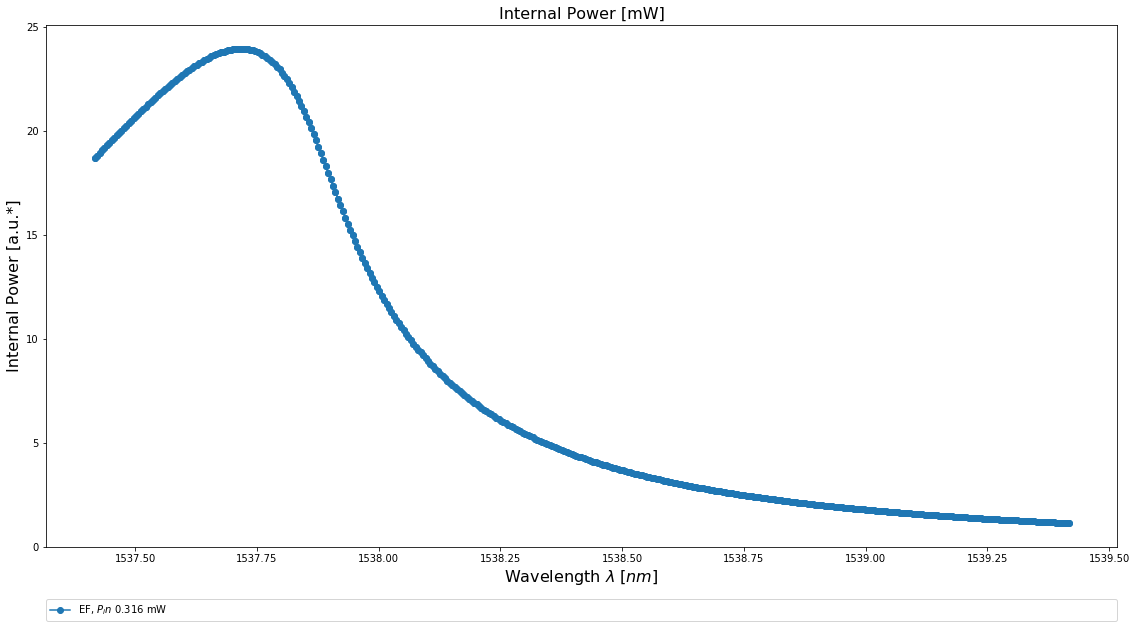

In [10]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
ax1 = fig.add_subplot(111)

#ax1.set_xlim([1538.60, 1538.75])

ul = []
dl = []

for I_i in range(I_size):
    if I_i == 0:
        ul.append(
            ax1.plot(1e9*f2w(ω_range[:]/(2*np.pi)*f0,), ñwga*I_range[I_i]*u['EF'][:,I_i,0], ls='-', marker='o',
                     label='EF, $P_in$ %.3f mW'%(ñwga*I_range[I_i]) )
        )
        dl.append(
            ax1.plot(1e9*f2w(ω_range[:]/(2*np.pi)*f0,), ñwga*I_range[I_i]*d['EF'][:,I_i,0], ls='-', marker='o',
                     color=ul[-1][0].get_color() )
        )
        plup = ñwga*I_range[I_i]*u['EF'][:,I_i,0]
        pldo = ñwga*I_range[I_i]*d['EF'][:,I_i,0]
        ax1.fill_between(1e9*f2w(ω_range[:]/(2*np.pi)*f0,), pldo, plup, where=plup>=pldo, interpolate=True, color=ul[-1][0].get_color(), alpha=0.2)
        
ax1.set_title( r'Internal Power [mW]', fontsize=16)
ax1.set_xlabel(r'Wavelength $\lambda$ $[nm]$', fontsize=16)
ax1.set_ylabel(r'Internal Power [a.u.*]', fontsize=16)

legend = ax1.legend(bbox_to_anchor=(0., -.05, 1., -.05), loc=2, ncol=8, mode="expand", borderaxespad=0.)

plt.show()
plt.close()

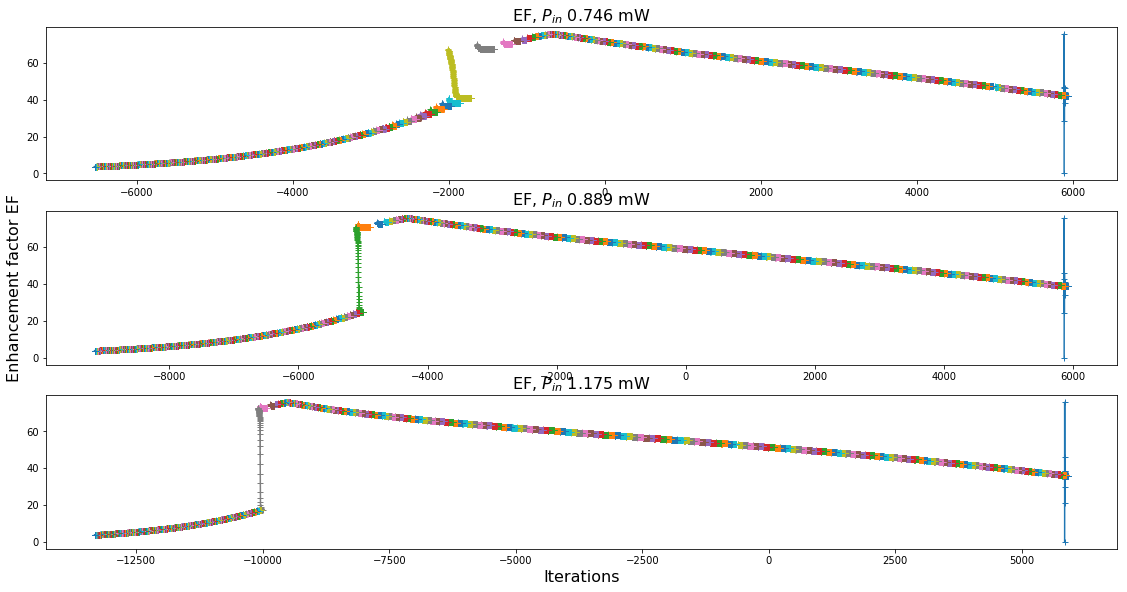

In [7]:
fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8

ax1 = fig.add_subplot(311)
counter = 0
for i in range(ω_size):
    counter += u['it'][i,3].astype(int)
    x = maxit-counter+range(int(maxit) )
    ax1.plot(x, u['EF'][i,3,::-1].T, ls='-', marker='+')
ax1.set_title( r'EF, $P_{in}$ %.3f mW'%(ñwga*I_range[3]), fontsize=16)

ax2 = fig.add_subplot(312)
counter = 0
for i in range(ω_size):
    counter += u['it'][i,4].astype(int)+1
    x =  maxit-counter+range(int(maxit) )
    ax2.plot(x, u['EF'][i,4,::-1].T, ls='-', marker='+')
ax2.set_title( r'EF, $P_{in}$ %.3f mW'%(ñwga*I_range[4]), fontsize=16)
ax2.set_ylabel(r'Enhancement factor EF', fontsize=16)

ax3 = fig.add_subplot(313)
counter = 0
for i in range(ω_size):
    counter += u['it'][i,5].astype(int)
    x = maxit-counter+range(int(maxit) )
    ax3.plot(x, u['EF'][i,5,::-1].T, ls='-', marker='+')
ax3.set_title( r'EF, $P_{in}$ %.3f mW'%(ñwga*I_range[6]), fontsize=16)
ax3.set_xlabel(r'Iterations', fontsize=16)

plt.show()
plt.close()

In [8]:
### save data to csv files
#he = ['\t%.2f'%x for x in E_range**2 ]
#head = 'Power'
#for x in he:
#    head += x
#print(head)
#
#ics = (1e9*f2w(ω_range*ω0) - 1.55e3).reshape(np.size(ω_range),1)
##print(ics)
#print(ics.shape)
#print(d['Ut'][:,:,0].shape)
#dat = np.concatenate( (ics, d['Ut'][:,:,0]), axis=1 )
#print(dat.shape)
#print(dat[0,:])
#
#np.savetxt("triangles.csv", dat, fmt='%.8e', delimiter="\t", header=head, comments='')#, newline=' \\')